<a href="https://colab.research.google.com/github/min290/projects_data_science/blob/main/LLM_DISEASE__BASED__FINE_TUNNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install libraries

In [1]:
!pip install -q kaggle
!pip install -q transformers accelerate bitsandbytes peft trl datasets scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 kB 39.2 MB/s eta 0:00:00


Dataset loading

In [2]:
import os,zipfile,json
os.makedirs("/root/.kaggle", exist_ok=True)
!mv "kaggle (9).json" /root/.kaggle/
os.chmod("/root/.kaggle/kaggle (9).json", 0o600)
print("Kaggle API set successfully!")

Kaggle API set successfully!


In [3]:
zip_path="/content/archive (19).zip"
extract_path="/content/data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("extracted files :",os.listdir(extract_path))

extracted files : ['DiseaseAndSymptoms.csv', 'Disease precaution.csv']


JSONL CREATION

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import os
csv_path = "/content/data/DiseaseAndSymptoms.csv"
df = pd.read_csv(csv_path)
symptom_cols = [c for c in df.columns if c.lower().startswith("symptom")]
print("Symptom columns:", symptom_cols[:10], "...")
def row_to_example(row):
    symptoms = [str(s).strip() for s in row[symptom_cols] if pd.notnull(s)]
    symptom_str = ", ".join(symptoms)

    disease = str(row["Disease"]).strip()

    example = {
        "instruction": "Identify the most likely disease pattern from the dataset based on these symptoms.",
        "input": symptom_str,
        "output": (
            f"Disease: {disease}\n"
            f"Explanation: These symptoms frequently appear together for {disease} "
            f"in the training dataset examples.\n"
            "Note: This is NOT medical or diagnostic advice. "
            "For any real health concerns, please consult a licensed doctor or emergency services."
        ),

        "label": disease
    }
    return example

examples = [row_to_example(r) for _, r in df.iterrows()]
print("Total examples:", len(examples))

train_data, test_data = train_test_split(examples, test_size=0.2, random_state=42, stratify=[e["label"] for e in examples])

os.makedirs("data_llm", exist_ok=True)

def write_jsonl(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for ex in data:
            f.write(json.dumps(ex, ensure_ascii=False) + "\n")

write_jsonl("data_llm/train.jsonl", train_data)
write_jsonl("data_llm/test.jsonl", test_data)

len(train_data), len(test_data)

Symptom columns: ['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10'] ...
Total examples: 4920


(3936, 984)

LLM fine tunning

In [5]:
from datasets import load_dataset
data_files={"train":"data_llm/train.jsonl","test":"data_llm/test.jsonl"}
raw_datasets=load_dataset("json",data_files=data_files,split={"train": "train", "test":"test"})
def format_example(example):
    return{
        "text": (
            f"Instruction: {example['instruction']}\n"
            f"Symptoms: {example['input']}\n\n"
            f"Response:\n{example['output']}"
        )
    }
datset=raw_datasets["train"].map(format_example)
datset_test=raw_datasets["test"].map(format_example)
datset[0]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3936 [00:00<?, ? examples/s]

Map:   0%|          | 0/984 [00:00<?, ? examples/s]

{'instruction': 'Identify the most likely disease pattern from the dataset based on these symptoms.',
 'input': 'back_pain, weakness_in_limbs, neck_pain, dizziness, loss_of_balance',
 'output': 'Disease: Cervical spondylosis\nExplanation: These symptoms frequently appear together for Cervical spondylosis in the training dataset examples.\nNote: This is NOT medical or diagnostic advice. For any real health concerns, please consult a licensed doctor or emergency services.',
 'label': 'Cervical spondylosis',
 'text': 'Instruction: Identify the most likely disease pattern from the dataset based on these symptoms.\nSymptoms: back_pain, weakness_in_limbs, neck_pain, dizziness, loss_of_balance\n\nResponse:\nDisease: Cervical spondylosis\nExplanation: These symptoms frequently appear together for Cervical spondylosis in the training dataset examples.\nNote: This is NOT medical or diagnostic advice. For any real health concerns, please consult a licensed doctor or emergency services.'}

In [6]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig
from trl import SFTTrainer
from transformers import TrainingArguments

base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# 4-bit quantization (QLoRA)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(base_model_name, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
output_dir = "tinyllama_disease_qlora"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    num_train_epochs=1,
    learning_rate=2e-4,
    logging_steps=50,
    save_strategy="epoch",
    eval_strategy="epoch",
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    bf16=torch.cuda.is_available(),
    report_to="none"
)
dataset_small = datset.select(range(200))
dataset_test_small = datset_test.select(range(100))
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset_small,
    eval_dataset=dataset_test_small,
    peft_config=lora_config,
    args=training_args,
)

trainer.train()

Adding EOS to train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.175300,0.189707,0.233118,25986.000000,0.953690


TrainOutput(global_step=200, training_loss=0.36965927600860593, metrics={'train_runtime': 128.7712, 'train_samples_per_second': 1.553, 'train_steps_per_second': 1.553, 'total_flos': 163264019226624.0, 'train_loss': 0.36965927600860593, 'epoch': 1.0})

In [8]:
save_dir = "tinyllama_disease_qlora_adapter"
trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print("Saved adapter to:", save_dir)

Saved adapter to: tinyllama_disease_qlora_adapter


In [10]:
from peft import AutoPeftModelForCausalLM
inference_model = AutoPeftModelForCausalLM.from_pretrained(
    save_dir,
    device_map="auto",)
inference_model.eval()


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(


In [11]:
import re
from tqdm import tqdm

def build_prompt(example):
    return (
        f"Instruction: {example['instruction']}\n"
        f"Symptoms: {example['input']}\n\n"
        "Response:\n"
    )

def extract_disease_from_output(text):
    """
    Try to extract the disease name from lines like:
    'Disease: dengue'
    'Possible condition: Dengue-like pattern (from dataset)'
    """
    m = re.search(r"Disease:\s*([^\n\r]+)", text, flags=re.IGNORECASE)
    if m:
        return m.group(1).strip()

    m2 = re.search(r"Possible\s+condition:\s*([^\n\r]+)", text, flags=re.IGNORECASE)
    if m2:
        return m2.group(1).strip()

    return "Unknown"

y_true = []
y_pred = []

for ex in tqdm(raw_datasets["test"]):
    prompt = build_prompt(ex)
    inputs = tokenizer(prompt, return_tensors="pt").to(inference_model.device)

    with torch.no_grad():
        output_ids = inference_model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            temperature=0.0
        )

    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    if "Response:" in decoded:
        generated_part = decoded.split("Response:", 1)[1]
    else:
        generated_part = decoded

    pred_disease = extract_disease_from_output(generated_part)
    y_pred.append(pred_disease)
    y_true.append(ex["label"])


100%|██████████| 984/984 [49:55<00:00,  3.04s/it]


EVALUATION MATRIX

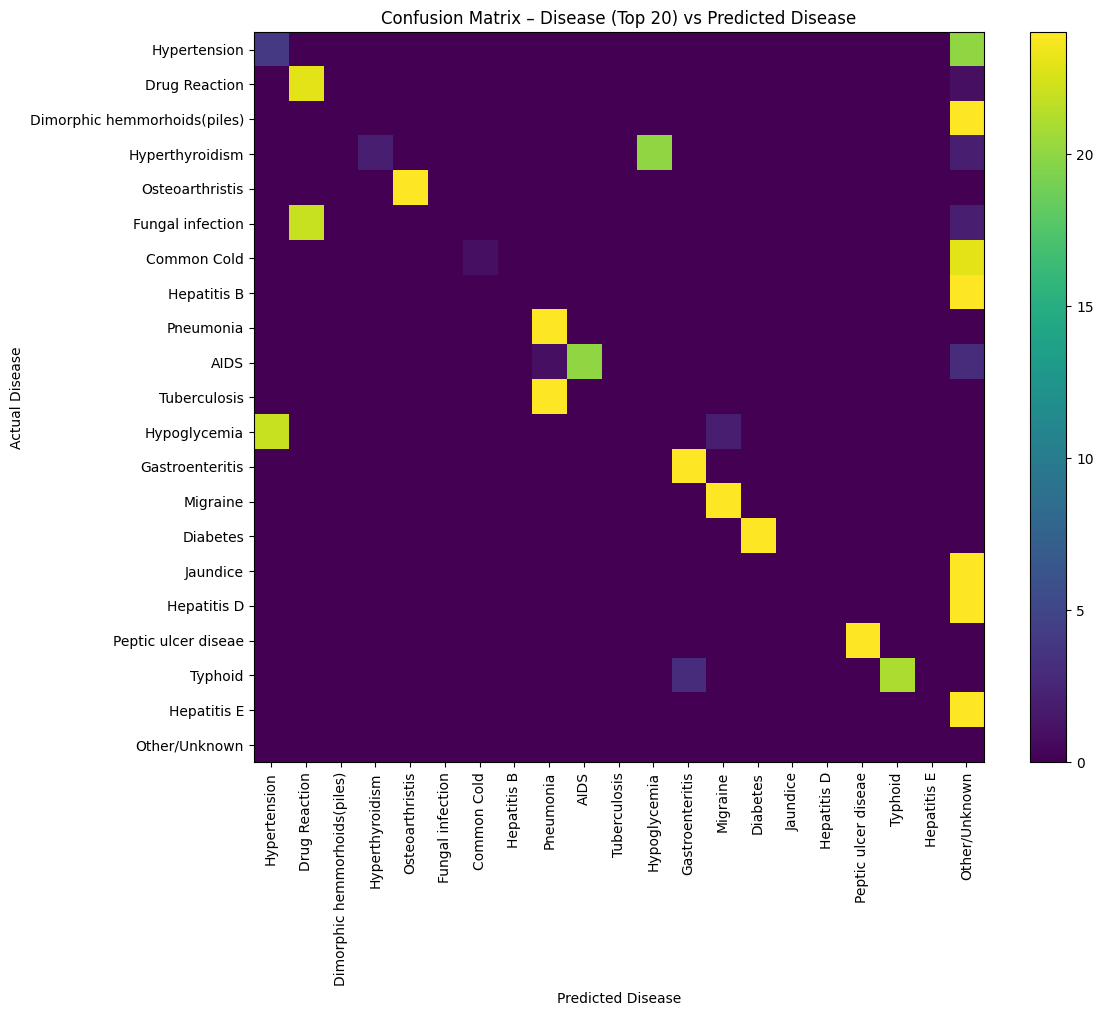

In [12]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
counter = Counter(y_true)
top_20_diseases = [d for d, _ in counter.most_common(20)]

# Filter to those
filtered_true = []
filtered_pred = []
for t, p in zip(y_true, y_pred):
    if t in top_20_diseases:
        filtered_true.append(t)
        filtered_pred.append(p if p in top_20_diseases else "Other/Unknown")

labels = top_20_diseases + ["Other/Unknown"]

cm = confusion_matrix(filtered_true, filtered_pred, labels=labels)

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix – Disease (Top 20) vs Predicted Disease")
plt.colorbar(im, ax=ax)

tick_marks = np.arange(len(labels))
ax.set_xticks(tick_marks)
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(tick_marks)
ax.set_yticklabels(labels)

ax.set_ylabel("Actual Disease")
ax.set_xlabel("Predicted Disease")

plt.tight_layout()
plt.savefig("confusion_matrix_top20.png", dpi=200)
plt.show()


DEMO QUERY

In [20]:
def query_model(symptoms_text: str):
    instruction = "Identify the most likely disease pattern from the dataset based on these symptoms."
    prompt = (
        f"Instruction: {instruction}\n"
        f"Symptoms: {symptoms_text}\n\n"
        "Response:\n"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(inference_model.device)

    with torch.no_grad():
        output_ids = inference_model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            temperature=0.0
        )

    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    if "Response:" in decoded:
        decoded = decoded.split("Response:", 1)[1].strip()

    return decoded
test_cases = [
    "Fever, headache, body pain",#test case1
    "Cough, sore throat, runny nose",#test case2
    "Abdominal pain, vomiting, diarrhea"#test case3
]
print("MODEL RESPONSES FOR 3 TEST CASES ARE:")
for i, symptoms in enumerate(test_cases, start=1):
    print(f"------ Test Case {i} ------")
    print("Symptoms:", symptoms)
    print("\nModel Output:\n")
    print(query_model(symptoms))


MODEL RESPONSES FOR 3 TEST CASES ARE:
------ Test Case 1 ------
Symptoms: Fever, headache, body pain

Model Output:

Disease: Malaria
Explanation: These symptoms frequently appear together for Malaria in the training dataset examples.
Note: This is NOT medical or diagnostic advice. For any real health concerns, please consult a licensed doctor or emergency services.
------ Test Case 2 ------
Symptoms: Cough, sore throat, runny nose

Model Output:

Disease: Bronchial Asthma
Explanation: These symptoms frequently appear together for Bronchial Asthma in the training dataset examples.
Note: This is NOT medical or diagnostic advice. For any real health concerns, please consult a licensed doctor or emergency services.
------ Test Case 3 ------
Symptoms: Abdominal pain, vomiting, diarrhea

Model Output:

Disease: Gastroenteritis
Explanation: These symptoms frequently appear together for Gastroenteritis in the training dataset examples.
Note: This is NOT medical or diagnostic advice. For any r